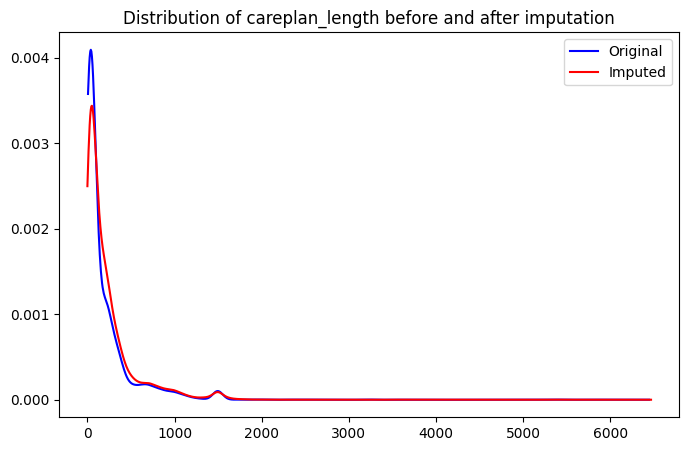

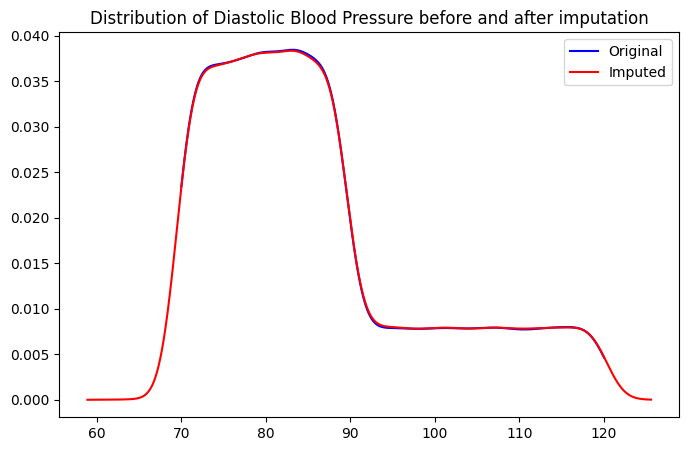

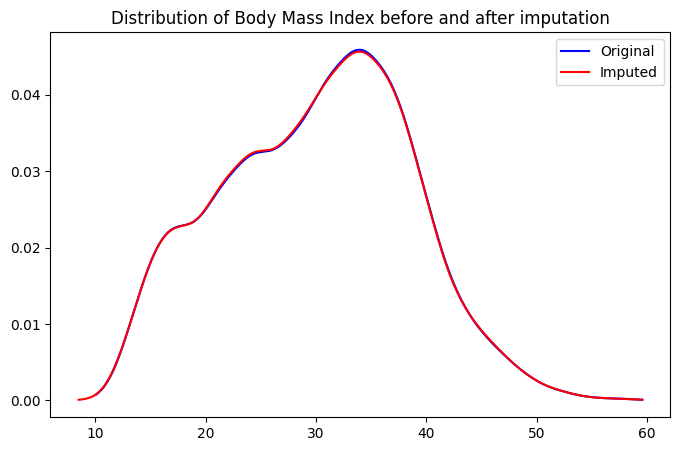

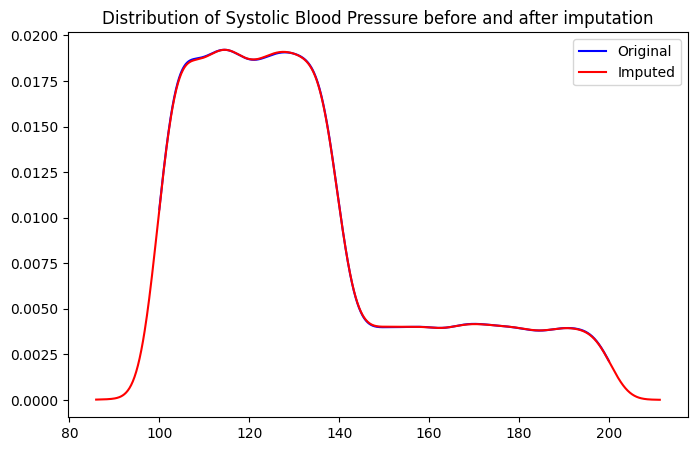

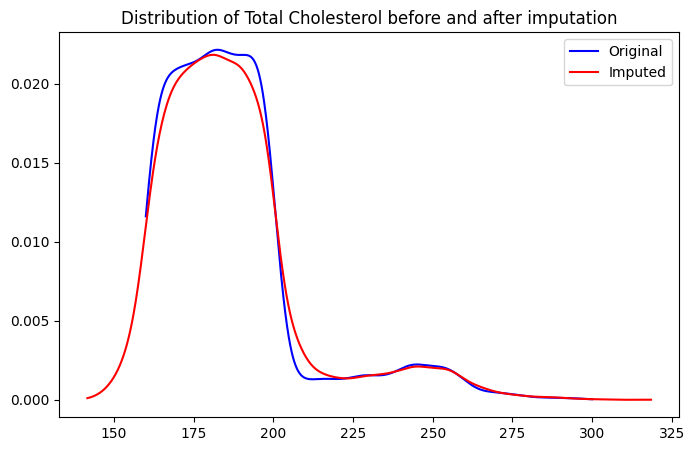

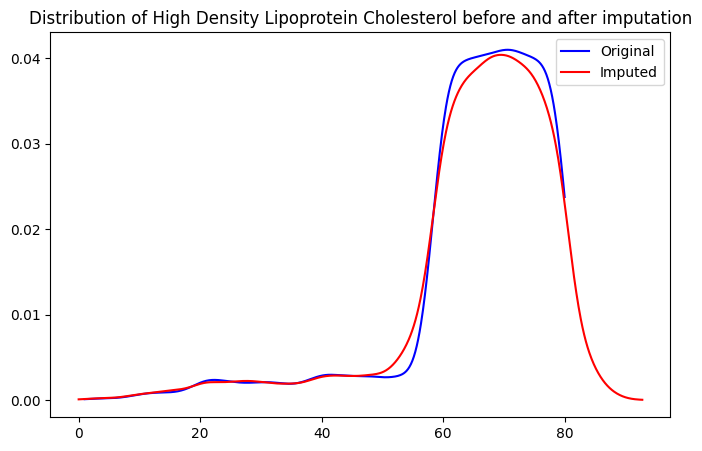

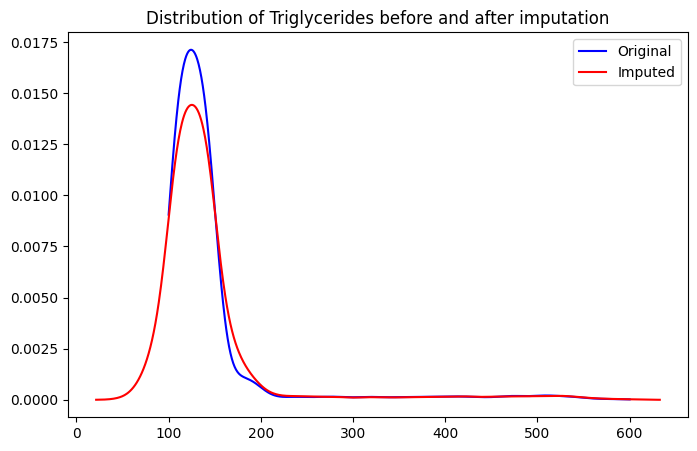

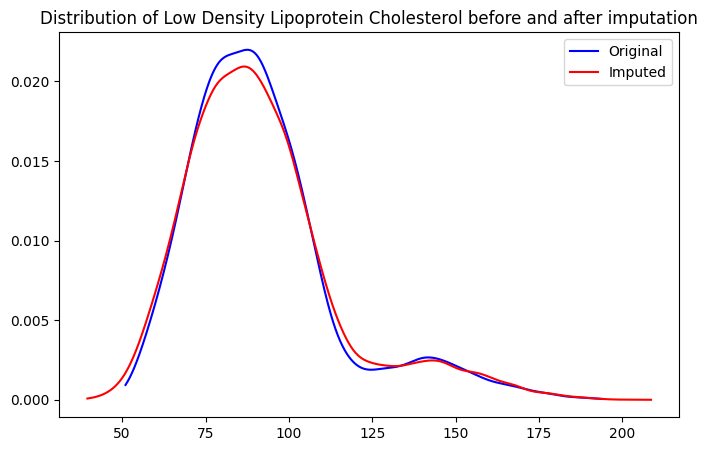

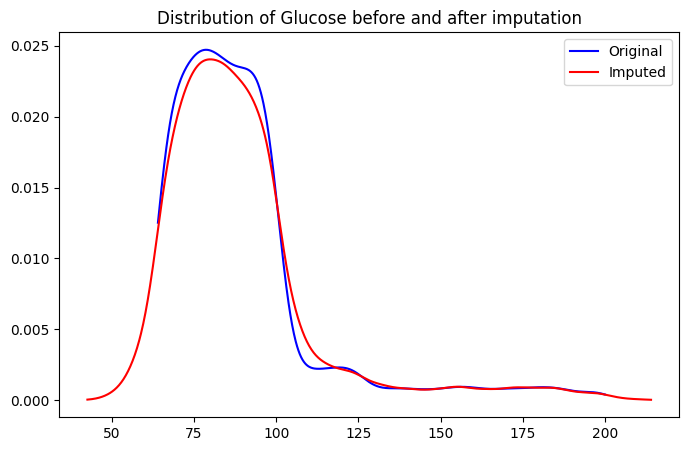

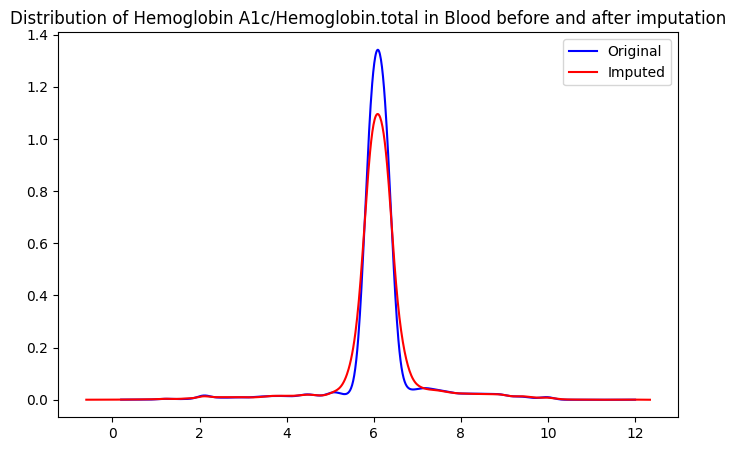

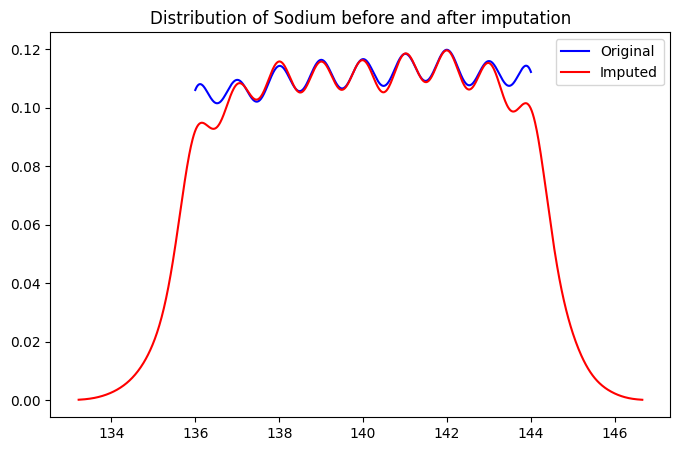

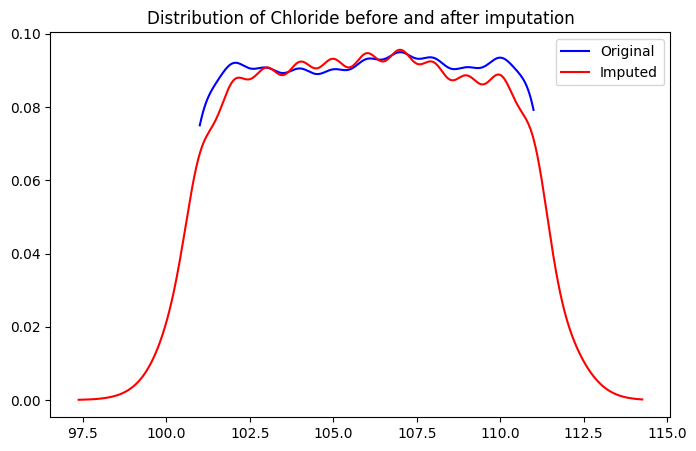

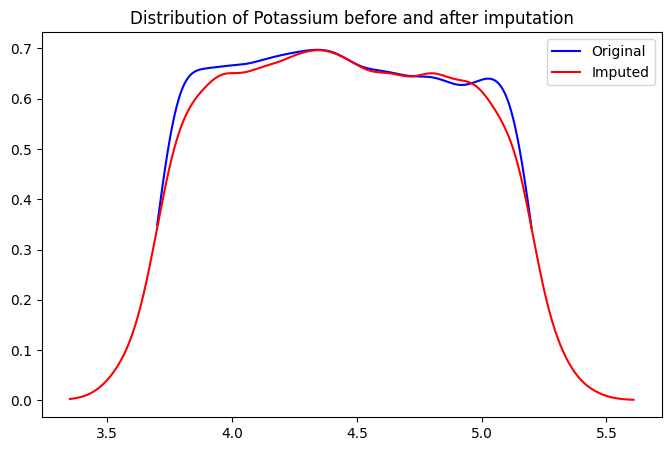

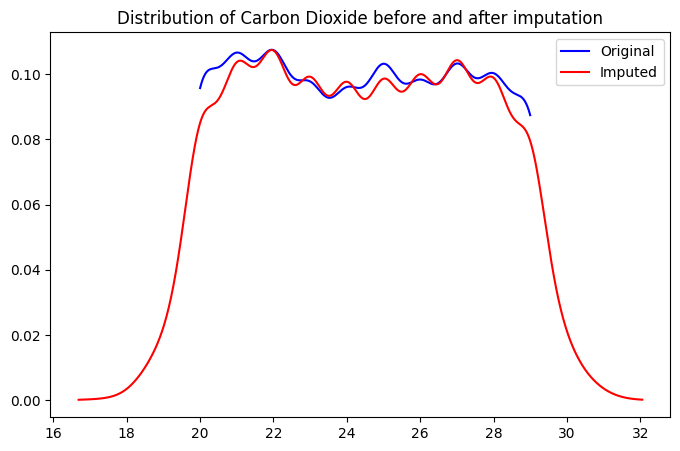

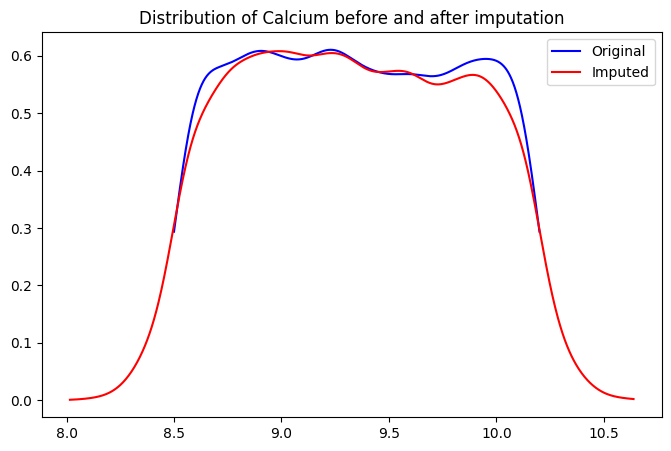

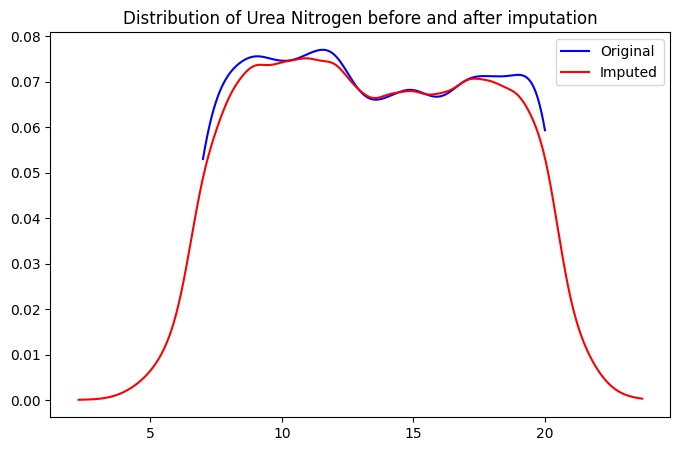

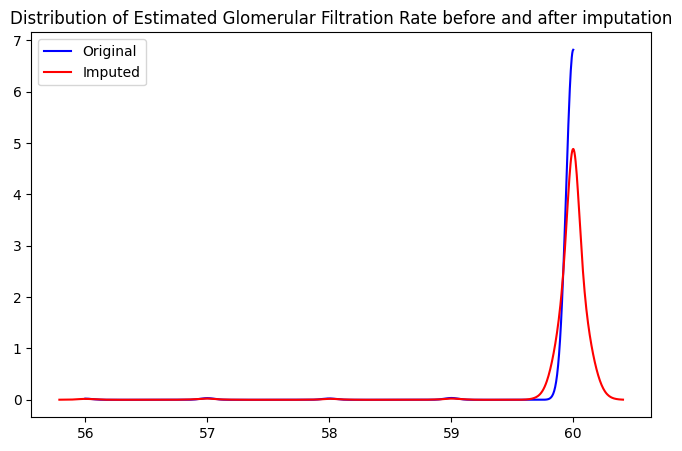

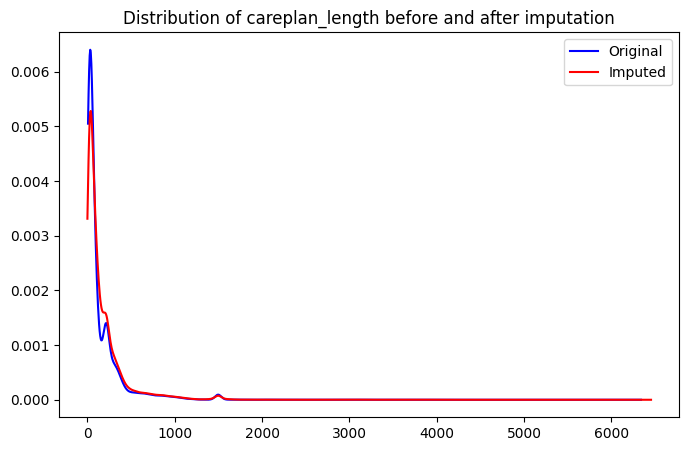

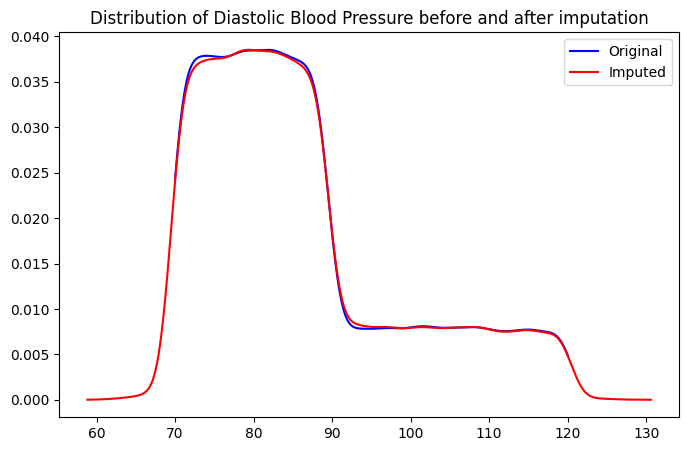

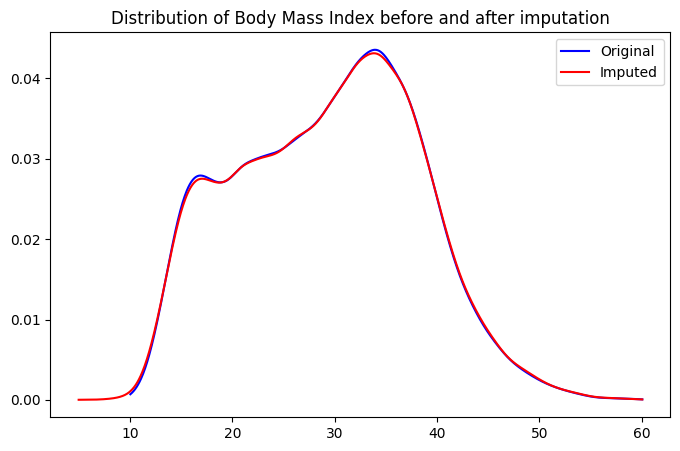

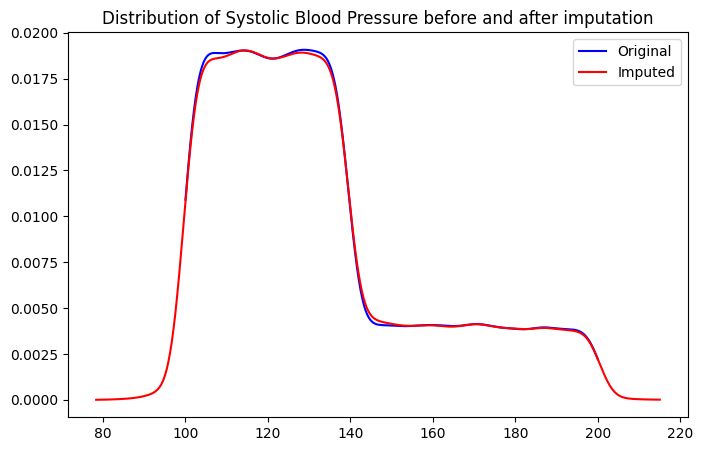

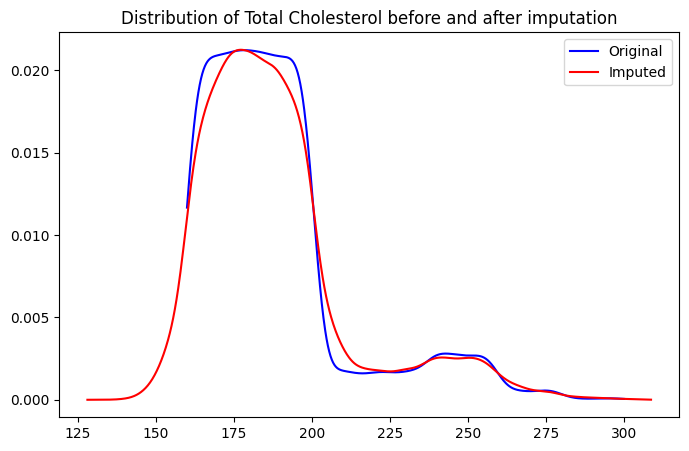

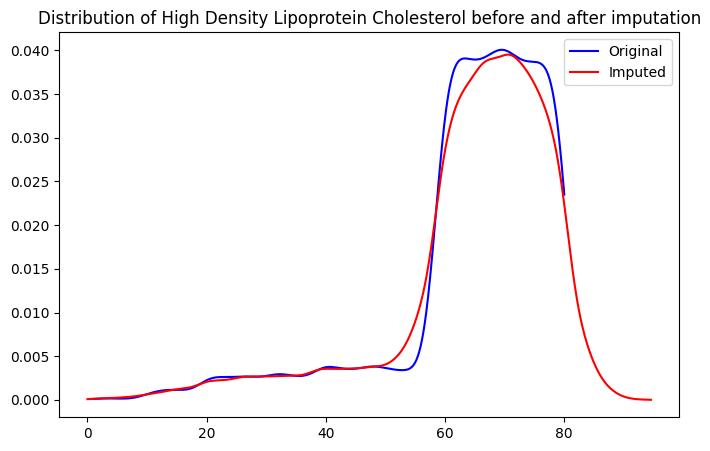

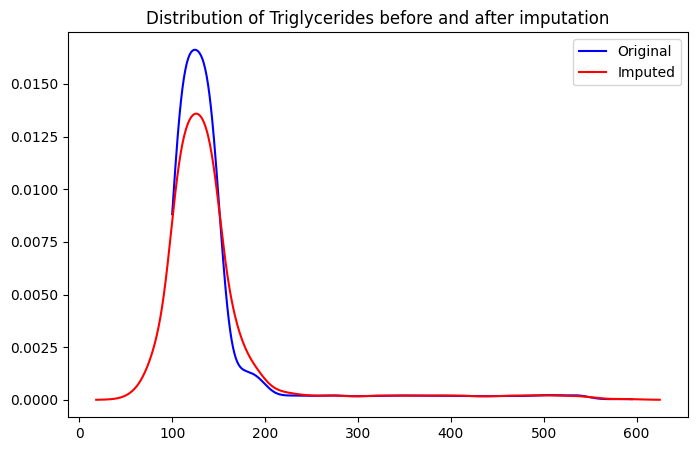

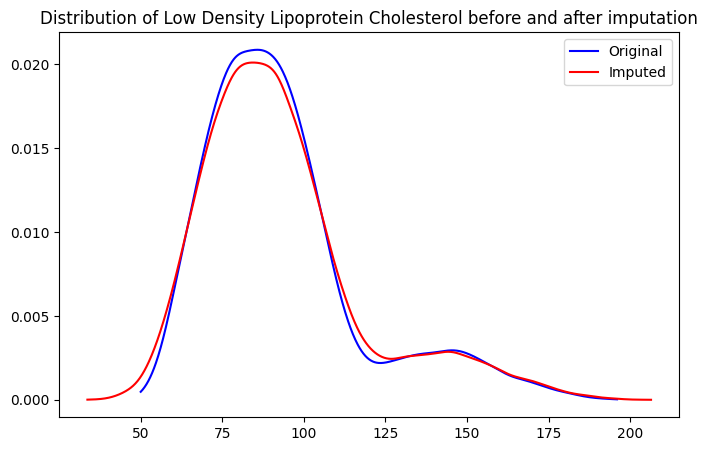

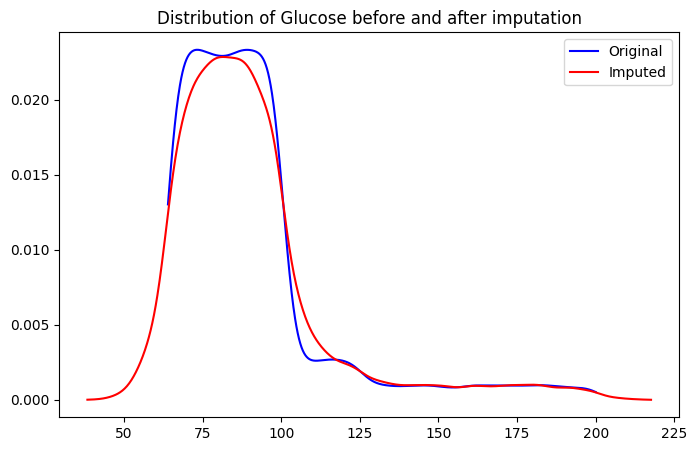

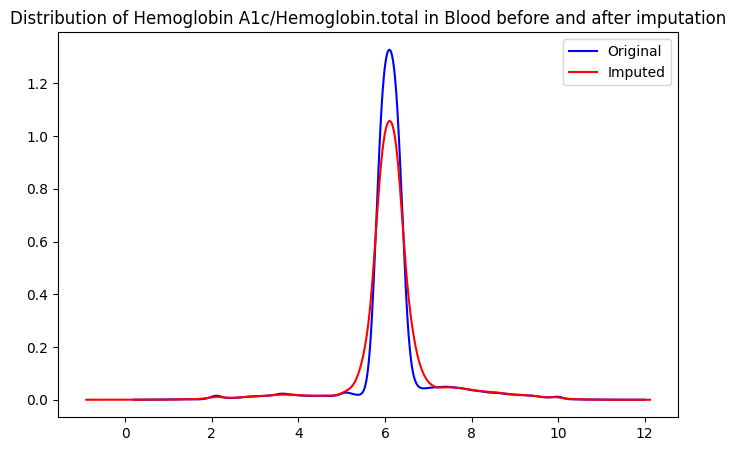

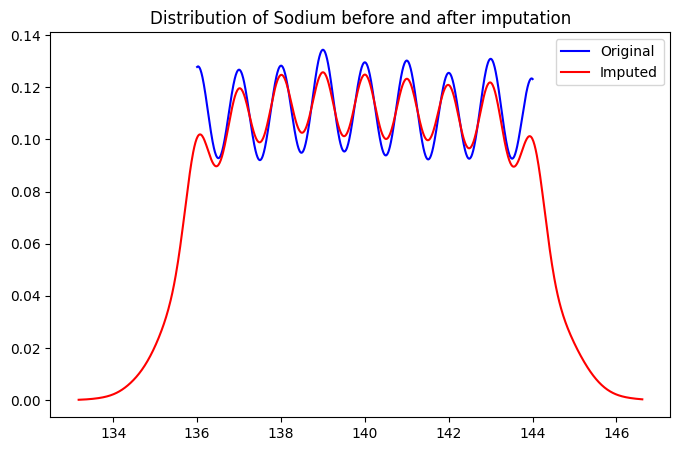

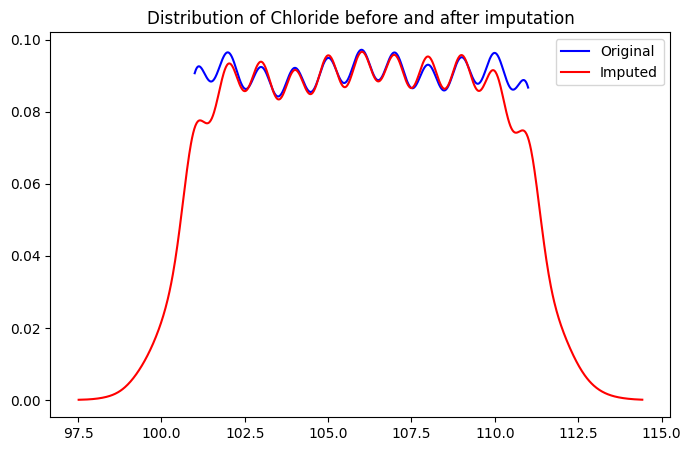

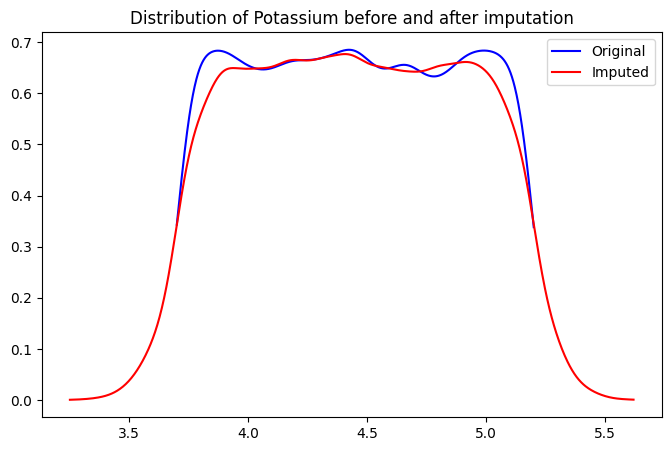

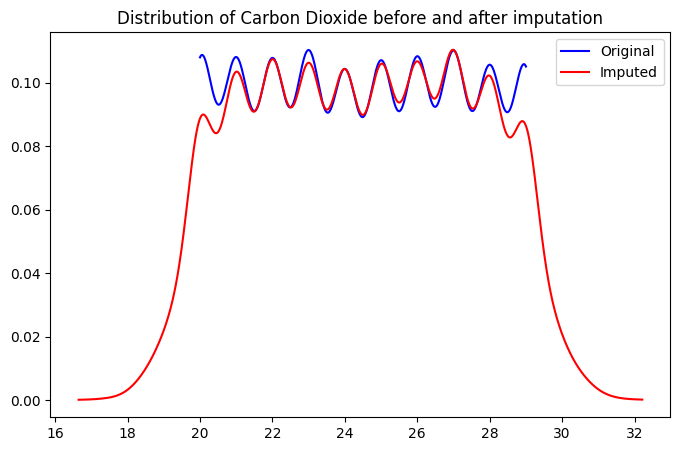

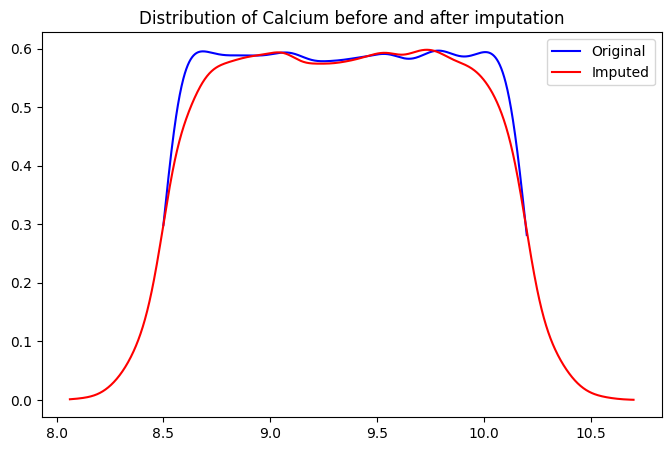

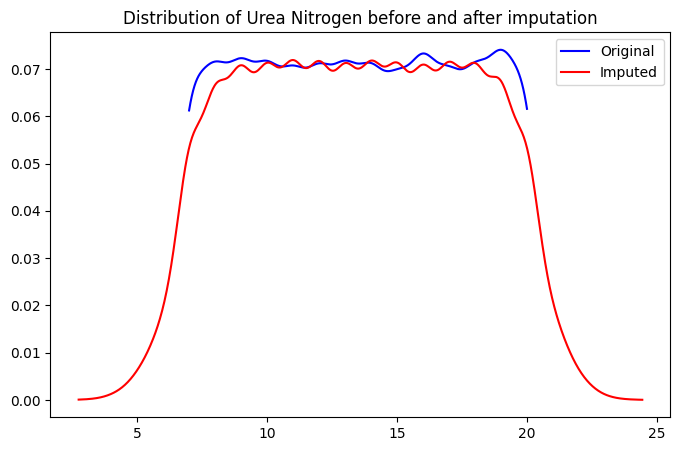

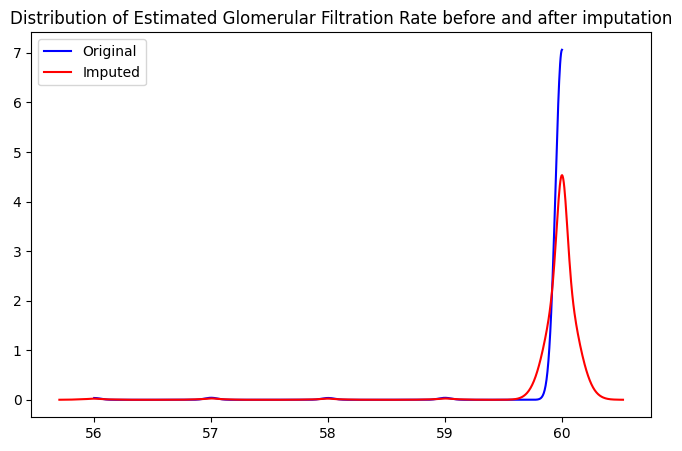

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_kde(data, label, color):
    kde = gaussian_kde(data.dropna())
    x_grid = np.linspace(data.min(), data.max(), 1000)
    plt.plot(x_grid, kde(x_grid), color=color, label=label)

def impute_with_kde(subset, continuous_columns):
    for col in continuous_columns:
        # Fit KDE on non-missing, positive values with a smaller bandwidth
        data = subset[col].dropna()
        data = data[data > 0]  # Ensure data is positive
        kde = gaussian_kde(data, bw_method=0.3)  # Smaller bandwidth

        # Plot original distribution
        plt.figure(figsize=(8, 5))
        plot_kde(data, 'Original', 'blue')

        # Sample and impute missing values
        missing_count = subset[col].isnull().sum()
        if missing_count > 0:
            sampled = kde.resample(missing_count)
            sampled = sampled[sampled > 0]  # Keep only positive values
            while len(sampled) < missing_count:  # Resample if necessary
                additional = kde.resample(missing_count - len(sampled))
                sampled = np.concatenate((sampled, additional[additional > 0]))

            # Use the minimum positive value for any remaining negative values
            min_positive = data.min()
            sampled = np.where(sampled <= 0, min_positive, sampled)

            # Impute missing values
            subset.loc[subset[col].isnull(), col] = sampled[:missing_count]

        # Plot imputed distribution
        plot_kde(subset[col], 'Imputed', 'red')
        plt.legend()
        plt.title(f"Distribution of {col} before and after imputation")
        plt.show()

    return subset

# Read the dataset
df = pd.read_csv('/content/final_df_new.csv')  # Replace with your actual file path

# Continuous columns to impute
continuous_columns = ['careplan_length', 'Diastolic Blood Pressure','Body Mass Index','Systolic Blood Pressure','Total Cholesterol','High Density Lipoprotein Cholesterol','Triglycerides','Low Density Lipoprotein Cholesterol','Glucose','Hemoglobin A1c/Hemoglobin.total in Blood','Sodium','Chloride','Potassium','Carbon Dioxide','Calcium','Urea Nitrogen','Estimated Glomerular Filtration Rate']

# Divide the dataset into subsets
df_positive = df[df['Viral_sinusitis_present'] == 1]
df_negative = df[df['Viral_sinusitis_present'] == 0]

# Impute missing values in both subsets
df_positive_imputed = impute_with_kde(df_positive.copy(), continuous_columns)
df_negative_imputed = impute_with_kde(df_negative.copy(), continuous_columns)

# Combine the subsets
df_imputed = pd.concat([df_positive_imputed, df_negative_imputed])

# Round values in continuous columns to the nearest integer
for col in continuous_columns:
    df_imputed[col] = df_imputed[col].round()

# Save the imputed dataset
df_imputed.to_csv('cont_imputed_dataset.csv', index=False)


In [ ]:
import pandas as pd

# Sample list of attributes
attributes = ['MARITAL', 'RACE', 'ETHNICITY','GENDER','encounter_type']

# Read the CSV file
df = pd.read_csv('/content/cont_imputed_dataset.csv')

# Convert only the attributes in the list to dummy variables
for attr in attributes:
    if attr in df.columns:
        dummies = pd.get_dummies(df[attr], prefix=attr)
        df = pd.concat([df, dummies], axis=1)
        df.drop(attr, axis=1, inplace=True)

# Save the final CSV with the dummy variables and other attributes
df.to_csv('imputed_encoded_dataset.csv', index=False)

print("Final DataFrame:")



Final DataFrame:


In [ ]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv('/content/imputed_dataset.csv')  # Replace 'your_dataset.csv' with your actual file path

# Drop the 'PATIENT' column
df = df.drop(columns=['PATIENT'])

# List of binary columns with missing values to impute
binary_columns = ['Animal dander (substance)', 'Grass pollen (substance)','House dust mite (organism)','Tree pollen (substance)','careplan_within_24','Influenza  seasonal  injectable  preservative free','SARS-COV-2 (COVID-19) vaccine  mRNA  spike protein  LNP  preservative free  30 mcg/0.3mL dose','SARS-COV-2 (COVID-19) vaccine  mRNA  spike protein  LNP  preservative free  100 mcg/0.5mL dose','SARS-COV-2 (COVID-19) vaccine  vector non-replicating  recombinant spike protein-Ad26  preservative free  0.5 mL','meningococcal MCV4P','Amoxicillin 250 MG / Clavulanate 125 MG Oral Tablet','Acetaminophen 325 MG Oral Tablet','Ibuprofen 100 MG Oral Tablet','Naproxen sodium 220 MG Oral Tablet','120 ACTUAT Fluticasone propionate 0.044 MG/ACTUAT Metered Dose Inhaler'] # Replace with your actual binary column names

for col in binary_columns:
    # Split the data into two parts: one where the binary column is not missing (for training)
    # and another where the binary column is missing (for prediction)
    train_data = df[df[col].notnull()]  # Data where the binary column is not missing
    predict_data = df[df[col].isnull()]  # Data where the binary column is missing

    # Before training, drop rows in the training data where any feature is NaN
    train_data = train_data.dropna(axis=0, how='any', subset=train_data.columns.difference([col]))

    # Separate features and target for training
    X_train = train_data.drop(columns=[col])  # Features for training
    y_train = train_data[col]  # Target variable for training

    # Train the decision tree
    clf = DecisionTreeClassifier()  # Initialize the decision tree classifier
    clf.fit(X_train, y_train)  # Train the decision tree

    # Predict missing values
    if not predict_data.empty:
        # Before prediction, drop rows in the prediction data where any feature is NaN
        X_predict = predict_data.dropna(axis=0, how='any', subset=predict_data.columns.difference([col]))

        # Predict missing values if there's data left after dropping NaNs
        if not X_predict.empty:
            predicted_values = clf.predict(X_predict.drop(columns=[col]))  # Features for prediction

            # Fill in the missing values in the original DataFrame
            df.loc[X_predict.index, col] = predicted_values

# Save the final dataset with imputed values
df.to_csv('imputed_dataset1.csv', index=False)
